c:\Users\manur\AppData\Local\Programs\Python\Python313\Lib\site-packages\tslearn\shapelets\shapelets.py:353: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Accuracy (shapelet classifier): 0.31654676258992803
Classification report:
               precision    recall  f1-score   support

           0     0.3165    1.0000    0.4809        88
           1     0.0000    0.0000    0.0000       190

    accuracy                         0.3165       278
   macro avg     0.1583    0.5000    0.2404       278
weighted avg     0.1002    0.3165    0.1522       278

Confusion matrix:
 [[ 88   0]
 [190   0]]


c:\Users\manur\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\manur\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\manur\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

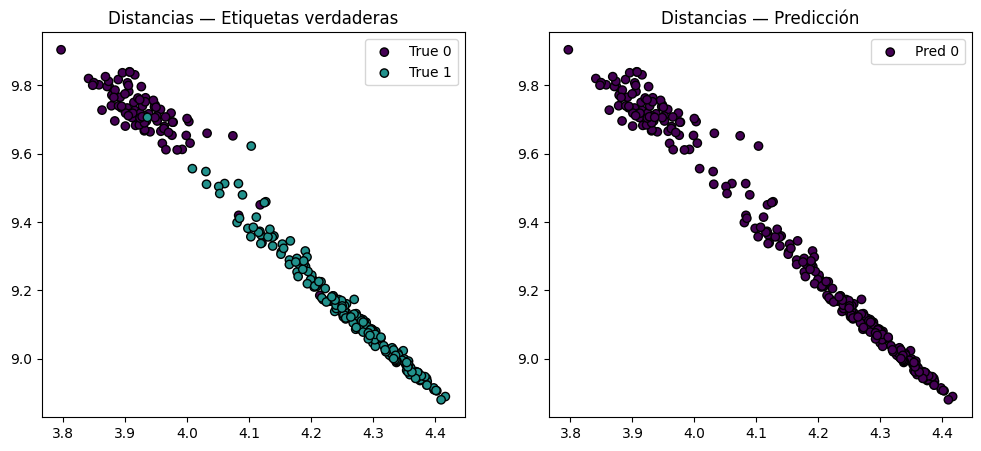

KMeans accuracy (mapped): 0.7697841726618705
ARI (sin mapping): 0.5500694700322416
Contingency matrix:
 [[  5   0  83]
 [ 55 131   4]
 [  0   0   0]]


In [3]:
# =========================
# ======= DEPENDENCIAS =====
# =========================
import pyabf
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import LearningShapelets
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, adjusted_rand_score
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from matplotlib import cm

# =========================
# ==== FUNCIONES UTILITARIAS ====
# =========================

def load_abf(file_path):
    abf = pyabf.ABF(file_path)
    signals = []
    for i in range(abf.sweepCount):
        abf.setSweep(i)
        signals.append(abf.sweepY)
    signal = np.concatenate(signals)
    dt = 1.0 / abf.dataRate
    time = np.arange(len(signal)) * dt
    return signal, time

def detect_spikes(signal, threshold=-35):
    spike_indices, _ = find_peaks(signal, height=threshold)
    return spike_indices

def detect_bursts(spike_times, burst_threshold=0.3):
    isi = np.diff(spike_times)
    burst_edges = np.where(isi >= burst_threshold)[0] + 1
    burst_splits = np.split(spike_times, burst_edges)
    bursts = [(b[0], b[-1]) for b in burst_splits if len(b) > 1]
    return bursts

def classify_bursts(bursts, signal, time):
    square_wave, parabolic, other = [], [], []
    for i, (start, end) in enumerate(bursts):
        mask = (time >= start) & (time <= end)
        burst_min = np.min(signal[mask])
        prev_mean = np.mean(signal[(time > bursts[i-1][1]) & (time < start)]) if i > 0 else np.nan
        next_mean = np.mean(signal[(time > end) & (time < bursts[i+1][0])]) if i < len(bursts)-1 else np.nan
        inter_mean = np.nanmean([prev_mean, next_mean])
        if burst_min > inter_mean:
            square_wave.append((start, end))
        elif burst_min < inter_mean:
            parabolic.append((start, end))
        else:
            other.append((start, end))
    return square_wave, parabolic, other

def normalize_y(signal_segment):
    return (signal_segment - np.mean(signal_segment)) / np.std(signal_segment)

def rescale_x(signal_segment, n_points=100):
    f = interp1d(np.linspace(0, 1, len(signal_segment)), signal_segment)
    return f(np.linspace(0, 1, n_points))

def extract_normalized_bursts(burst_list, signal, time, n_points=100):
    normalized_bursts = []
    for start, end in burst_list:
        mask = (time >= start) & (time <= end)
        segment = signal[mask]
        segment_rescaled = rescale_x(segment, n_points)
        segment_normalized = normalize_y(segment_rescaled)
        normalized_bursts.append(segment_normalized)
    return normalized_bursts

# =========================
# ==== PIPELINE PRINCIPAL ====
# =========================

file_path = "bursting/cell89basal.abf"
signal, time = load_abf(file_path)

spike_indices = detect_spikes(signal)
spike_times = time[spike_indices]
bursts = detect_bursts(spike_times)

square_wave_bursts, parabolic_bursts, other_bursts = classify_bursts(bursts, signal, time)

# --- Normalización ---
n_points = 100
square_norm = extract_normalized_bursts(square_wave_bursts, signal, time, n_points)
parabolic_norm = extract_normalized_bursts(parabolic_bursts, signal, time, n_points)
other_norm = extract_normalized_bursts(other_bursts, signal, time, n_points)

all_norm = square_norm + parabolic_norm + other_norm
labels = [0]*len(square_norm) + [1]*len(parabolic_norm) + [2]*len(other_norm)

X = np.array(all_norm)[:, :, np.newaxis]
y = np.array(labels)
X = TimeSeriesScalerMinMax().fit_transform(X)

# --- Shapelets ---
n_shapelets = 3
n_shapelets_per_size = {n_points: n_shapelets}

shp_clf = LearningShapelets(
    n_shapelets_per_size=n_shapelets_per_size,
    weight_regularizer=1e-4,
    optimizer=Adam(0.01),
    max_iter=300,
    verbose=0,
    scale=False,
    random_state=42
)
shp_clf.fit(X, y)

distances = shp_clf.transform(X)
if distances.shape[1] >= 2:
    dist2d = distances[:, :2]
else:
    dist2d = np.hstack([distances, distances])

# --- Predicciones supervisadas ---
W, b = shp_clf.model_.get_layer("classification").get_weights()
scores = distances.dot(W) + b
y_pred = np.argmax(scores, axis=1)

print("Accuracy (shapelet classifier):", accuracy_score(y, y_pred))
print("Classification report:\n", classification_report(y, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y, y_pred))

# --- Visualización supervisada ---
viridis = cm.get_cmap('viridis', 3)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i, lbl in enumerate(np.unique(y)):
    ax[0].scatter(dist2d[y == lbl, 0], dist2d[y == lbl, 1],
                  label=f'True {lbl}', edgecolors='k',
                  c=[viridis(i/2)]*np.sum(y == lbl))
ax[0].set_title('Distancias — Etiquetas verdaderas')
ax[0].legend()

for i, lbl in enumerate(np.unique(y_pred)):
    ax[1].scatter(dist2d[y_pred == lbl, 0], dist2d[y_pred == lbl, 1],
                  label=f'Pred {lbl}', edgecolors='k',
                  c=[viridis(i/2)]*np.sum(y_pred == lbl))
ax[1].set_title('Distancias — Predicción')
ax[1].legend()
plt.show()

# --- Clustering no supervisado ---
kmeans = KMeans(n_clusters=3, random_state=42).fit(distances)
cluster_labels = kmeans.labels_

cont = confusion_matrix(y, cluster_labels)
row_ind, col_ind = linear_sum_assignment(-cont)
mapping = {col: row for row, col in zip(row_ind, col_ind)}
cluster_to_class = np.array([mapping[c] for c in cluster_labels])

print("KMeans accuracy (mapped):", accuracy_score(y, cluster_to_class))
print("ARI (sin mapping):", adjusted_rand_score(y, cluster_labels))
print("Contingency matrix:\n", cont)

c:\Users\manur\AppData\Local\Programs\Python\Python313\Lib\site-packages\tslearn\shapelets\shapelets.py:353: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


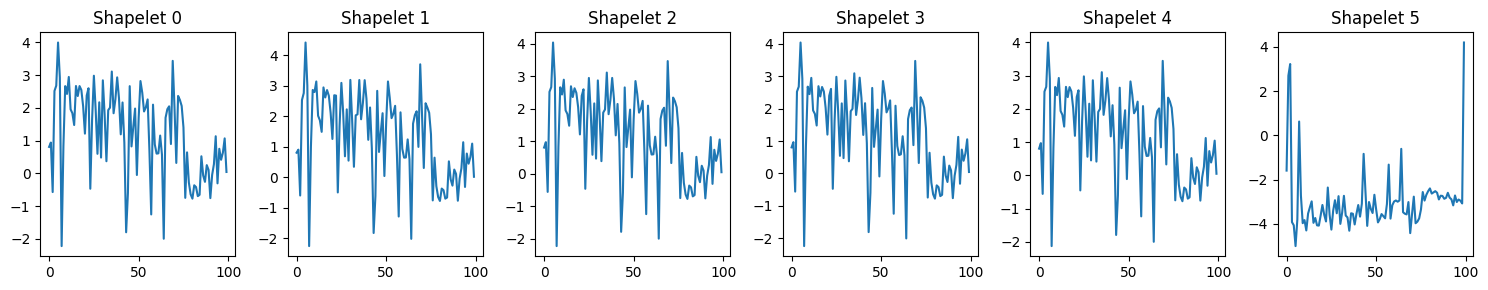

Accuracy (shapelet classifier): 0.31654676258992803
Classification report:
               precision    recall  f1-score   support

           0     0.3165    1.0000    0.4809        88
           1     0.0000    0.0000    0.0000       190

    accuracy                         0.3165       278
   macro avg     0.1583    0.5000    0.2404       278
weighted avg     0.1002    0.3165    0.1522       278

Confusion matrix:
 [[ 88   0]
 [190   0]]


c:\Users\manur\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\manur\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\manur\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

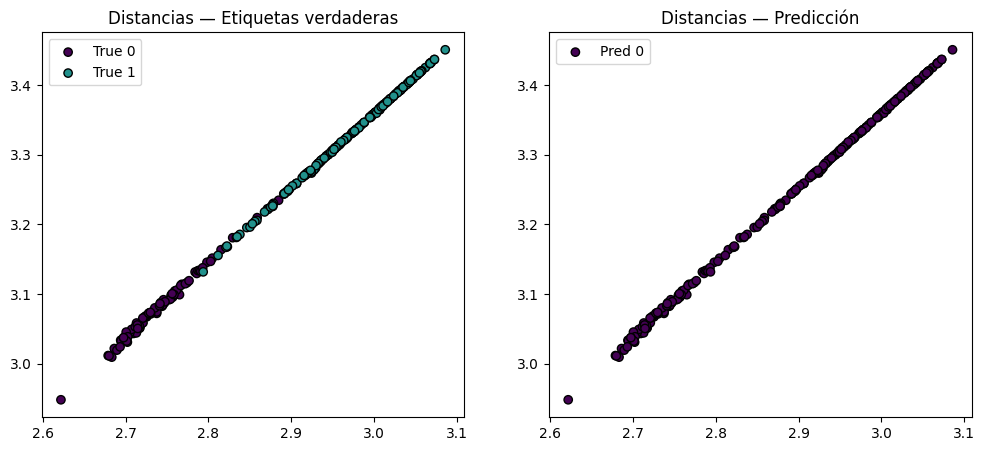

KMeans accuracy (mapped): 0.7589928057553957
ARI (sin mapping): 0.5456840727658787
Contingency matrix:
 [[  5   0  83]
 [ 59 128   3]
 [  0   0   0]]


In [4]:
# =========================
# ======= DEPENDENCIAS =====
# =========================
import pyabf
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import LearningShapelets
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, adjusted_rand_score
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from matplotlib import cm

# =========================
# ==== FUNCIONES UTILITARIAS ====
# =========================

def load_abf(file_path):
    abf = pyabf.ABF(file_path)
    signals = []
    for i in range(abf.sweepCount):
        abf.setSweep(i)
        signals.append(abf.sweepY)
    signal = np.concatenate(signals)
    dt = 1.0 / abf.dataRate
    time = np.arange(len(signal)) * dt
    return signal, time

def detect_spikes(signal, threshold=-35):
    spike_indices, _ = find_peaks(signal, height=threshold)
    return spike_indices

def detect_bursts(spike_times, burst_threshold=0.3):
    isi = np.diff(spike_times)
    burst_edges = np.where(isi >= burst_threshold)[0] + 1
    burst_splits = np.split(spike_times, burst_edges)
    bursts = [(b[0], b[-1]) for b in burst_splits if len(b) > 1]
    return bursts

def classify_bursts(bursts, signal, time):
    square_wave, parabolic, other = [], [], []
    for i, (start, end) in enumerate(bursts):
        mask = (time >= start) & (time <= end)
        burst_min = np.min(signal[mask])
        prev_mean = np.mean(signal[(time > bursts[i-1][1]) & (time < start)]) if i > 0 else np.nan
        next_mean = np.mean(signal[(time > end) & (time < bursts[i+1][0])]) if i < len(bursts)-1 else np.nan
        inter_mean = np.nanmean([prev_mean, next_mean])
        if burst_min > inter_mean:
            square_wave.append((start, end))
        elif burst_min < inter_mean:
            parabolic.append((start, end))
        else:
            other.append((start, end))
    return square_wave, parabolic, other

def normalize_y(signal_segment):
    return (signal_segment - np.mean(signal_segment)) / np.std(signal_segment)

def rescale_x(signal_segment, n_points=100):
    f = interp1d(np.linspace(0, 1, len(signal_segment)), signal_segment)
    return f(np.linspace(0, 1, n_points))

def extract_normalized_bursts(burst_list, signal, time, n_points=100):
    normalized_bursts = []
    for start, end in burst_list:
        mask = (time >= start) & (time <= end)
        segment = signal[mask]
        segment_rescaled = rescale_x(segment, n_points)
        segment_normalized = normalize_y(segment_rescaled)
        normalized_bursts.append(segment_normalized)
    return normalized_bursts

# =========================
# ==== PIPELINE PRINCIPAL ====
# =========================

file_path = "bursting/cell89basal.abf"
signal, time = load_abf(file_path)

spike_indices = detect_spikes(signal)
spike_times = time[spike_indices]
bursts = detect_bursts(spike_times)

square_wave_bursts, parabolic_bursts, other_bursts = classify_bursts(bursts, signal, time)

# --- Normalización ---
n_points = 100
square_norm = extract_normalized_bursts(square_wave_bursts, signal, time, n_points)
parabolic_norm = extract_normalized_bursts(parabolic_bursts, signal, time, n_points)
other_norm = extract_normalized_bursts(other_bursts, signal, time, n_points)

all_norm = square_norm + parabolic_norm + other_norm
labels = [0]*len(square_norm) + [1]*len(parabolic_norm) + [2]*len(other_norm)

X = np.array(all_norm)[:, :, np.newaxis]
y = np.array(labels)
X = TimeSeriesScalerMinMax().fit_transform(X)

# --- Shapelets ---
n_shapelets = 6  # más shapelets para mayor capacidad
n_shapelets_per_size = {n_points: n_shapelets}

shp_clf = LearningShapelets(
    n_shapelets_per_size=n_shapelets_per_size,
    weight_regularizer=1e-4,
    optimizer=Adam(0.01),
    max_iter=800,  # más iteraciones
    verbose=0,
    scale=False,
    random_state=42
)
shp_clf.fit(X, y)

# --- Visualizar shapelets aprendidas ---
learned_shapelets = shp_clf.shapelets_as_time_series_
fig, axes = plt.subplots(1, len(learned_shapelets), figsize=(15, 3))
for i, shp in enumerate(learned_shapelets):
    axes[i].plot(shp.ravel())
    axes[i].set_title(f"Shapelet {i}")
plt.tight_layout()
plt.show()

# --- Transformación a distancias ---
distances = shp_clf.transform(X)
dist2d = distances[:, :2] if distances.shape[1] >= 2 else np.hstack([distances, distances])

# --- Predicciones supervisadas ---
W, b = shp_clf.model_.get_layer("classification").get_weights()
scores = distances.dot(W) + b
y_pred = np.argmax(scores, axis=1)

print("Accuracy (shapelet classifier):", accuracy_score(y, y_pred))
print("Classification report:\n", classification_report(y, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y, y_pred))

# --- Visualización supervisada ---
viridis = cm.get_cmap('viridis', 3)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i, lbl in enumerate(np.unique(y)):
    ax[0].scatter(dist2d[y == lbl, 0], dist2d[y == lbl, 1],
                  label=f'True {lbl}', edgecolors='k',
                  c=[viridis(i/2)]*np.sum(y == lbl))
ax[0].set_title('Distancias — Etiquetas verdaderas')
ax[0].legend()

for i, lbl in enumerate(np.unique(y_pred)):
    ax[1].scatter(dist2d[y_pred == lbl, 0], dist2d[y_pred == lbl, 1],
                  label=f'Pred {lbl}', edgecolors='k',
                  c=[viridis(i/2)]*np.sum(y_pred == lbl))
ax[1].set_title('Distancias — Predicción')
ax[1].legend()
plt.show()

# --- Clustering no supervisado ---
kmeans = KMeans(n_clusters=3, random_state=42).fit(distances)
cluster_labels = kmeans.labels_

cont = confusion_matrix(y, cluster_labels)
row_ind, col_ind = linear_sum_assignment(-cont)
mapping = {col: row for row, col in zip(row_ind, col_ind)}
cluster_to_class = np.array([mapping[c] for c in cluster_labels])

print("KMeans accuracy (mapped):", accuracy_score(y, cluster_to_class))
print("ARI (sin mapping):", adjusted_rand_score(y, cluster_labels))
print("Contingency matrix:\n", cont)